In [27]:
%run __init__.py
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# TODO. Remove

import pandas as pd

csv_path = "/home/konstantin/datasets/MegaDepthDataset/SceneInfo/test_megadepth.csv"

# im_name = "/home/konstantin/datasets/MegaDepthDataset/Undistorted_SfM/0001/images/3442164011_022e239e78_o.jpg"

# id = 276
# id = 323
id = 657
# id = 783

warp_annotations = pd.read_csv(csv_path, index_col=[0])
warp_annotations = warp_annotations[id:id+2]

# warp_annotations

warp_annotations.to_csv("/home/konstantin/datasets/MegaDepthDataset/SceneInfo/analyze_megadepth.csv")

In [29]:
model_config_path = '../configs/model.yaml'
mode_config_path = '../configs/analyze.yaml'

model_name = 'NetVGG'
model_version = 'v1'

mode = 'analyze'
dataset = 'megadepth'
gpu = '2'

experiment = create_experiment(model_config_path, mode_config_path, model_name, model_version,
                               mode, dataset, gpu, '../')

model
	         grid_size : 8
	   descriptor_size : 64
	        batch_norm : True
	soft_nms_kernel_size : 7
	   nms_kernel_size : 3
	             top_k : 256
	   checkpoint_name : 5_ems=0.3778786
criterion
	det
		   nms_kernel_size : 3
		             top_k : 256
		 gauss_kernel_size : 7
		       gauss_sigma : 0.5
		            lambda : 4.0
	det_conf
		            lambda : 1.0
	desc
		            margin : 1.0
		            lambda : 1.0
	ep
		         px_thresh : 3.0
		            lambda : 0.003
dataset
	analyze
		megadepth
			      dataset_root : /home/konstantin/datasets/MegaDepthDataset
			   scene_info_root : /home/konstantin/datasets/MegaDepthDataset/SceneInfo
			          csv_path : /home/konstantin/datasets/MegaDepthDataset/SceneInfo/analyze_megadepth.csv
			            height : 240
			             width : 320
			      to_grayscale : True
			           sources : True
loader
	analyze
		        batch_size : 1
		       num_samples : 1
		           shuffle : False
		       num_workers

In [30]:
(batch, endpoint), metrics = experiment.run()

Model 5_ems=0.3778786 is loaded


/home/konstantin/.local/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [31]:
image1_name = batch.get(du.IMAGE1_NAME)
image2_name = batch.get(du.IMAGE2_NAME)

image1 = batch.get(du.IMAGE1)
image2 = batch.get(du.IMAGE2)

depth1 = batch.get(du.DEPTH1)
depth2 = batch.get(du.DEPTH2)

desc1 = endpoint[eu.DESC1]
desc2 = endpoint[eu.DESC2]

score1 = endpoint[eu.SCORE1]
score2 = endpoint[eu.SCORE2]

sal_score1 = endpoint[eu.SAL_SCORE1]
sal_score2 = endpoint[eu.SAL_SCORE2]

conf_score1 = endpoint[eu.CONF_SCORE1]
conf_score2 = endpoint[eu.CONF_SCORE2]

intrinsics1 = batch.get(du.INTRINSICS1).to(experiment.device)
intrinsics2 = batch.get(du.INTRINSICS2).to(experiment.device)

extrinsics1 = batch.get(du.EXTRINSICS1).to(experiment.device)
extrinsics2 = batch.get(du.EXTRINSICS2).to(experiment.device)

shift_scale1 = batch.get(du.SHIFT_SCALE1).to(experiment.device)
shift_scale2 = batch.get(du.SHIFT_SCALE2).to(experiment.device)

kp1 = endpoint[eu.KP1]
kp2 = endpoint[eu.KP2]

w_kp1 = endpoint[eu.W_KP1]
w_kp2 = endpoint[eu.W_KP2]

w_vis_kp1_mask = endpoint[eu.W_VIS_KP1_MASK]
w_vis_kp2_mask = endpoint[eu.W_VIS_KP2_MASK]

kp1_desc = endpoint[eu.KP1_DESC]
kp2_desc = endpoint[eu.KP2_DESC]

In [32]:
from Net.source.nn.net.criterions.loc_criterions import EpipolarLoss, PoseLoss

ep_loss = EpipolarLoss(3.0, 0.004)
pose_loss = PoseLoss(3.0, 1.0, loss_version='2')

# ep_loss = EpipolarLoss(3.0, 0.075)
# pose_loss = PoseLoss(3.0, 0.25)

In [33]:
dkp1 = torch.nn.Parameter(torch.zeros_like(kp1, requires_grad=True))
dkp2 = torch.nn.Parameter(torch.zeros_like(kp2, requires_grad=True))

optimizer = torch.optim.Adam([dkp1, dkp2], lr=0.0001)

In [34]:
from Net.source.utils.math_utils import compose_gt_transform, E_param
from Net.source.utils.pose_utils import estimate_param_rel_pose_opencv

def estimate_E_param_error(kp1, kp2, intrinsics1, intrinsics2, extrinsics1, extrinsics2, shift_scale1, shift_scale2):    
    _kp1 = kp1 + dkp1
    _kp2 = kp2 + dkp2
    
    _w_kp1, _w_kp2, _w_vis_kp1_mask, _w_vis_kp2_mask = warp_points(_kp1, _kp2, image1.shape, image2.shape, batch)
    
    est_E_param, success_mask = estimate_param_rel_pose_opencv(_kp1, _kp2, _w_kp1, _w_kp2, _w_vis_kp1_mask, _w_vis_kp2_mask,
                                                               shift_scale1, shift_scale2, intrinsics1, intrinsics2, 3.0)
    
    gt_E_param = compose_gt_transform(intrinsics1, intrinsics2, extrinsics1, extrinsics2, E_param)
    
    print("Estimated: ", est_E_param)
    print("Ground-truth: ", gt_E_param)
    
    loss = (est_E_param - gt_E_param).norm(dim=-1)
    
    print("Loss:", loss)

In [35]:
from Net.source.nn.net.utils.endpoint_utils import warp_points
from torch.nn.functional import normalize

def grad(loss_function, zero_grad=True, step=True):
    if zero_grad:
        optimizer.zero_grad()
    
    _kp1 = kp1 + dkp1
    _kp2 = kp2 + dkp2
    
    _w_kp1, _w_kp2, _w_vis_kp1_mask, _w_vis_kp2_mask = warp_points(_kp1, _kp2, image1.shape, image2.shape, batch)
    
    loss1 = loss_function(_kp1, _kp2, _w_kp1, _w_kp2, _w_vis_kp1_mask, _w_vis_kp2_mask,
                          shift_scale1, shift_scale2, intrinsics1, intrinsics2, extrinsics1, extrinsics2)
    loss1.backward()
    
    if step:
        print(f"Loss error: {loss1}")
        
        optimizer.step()
    else:
        return dkp1.grad.clone(), dkp2.grad.clone()

In [36]:
for i in range(1, 10):
    print(f"Iteration: {i}")
    
#     grad(ep_loss)
#     grad(pose_loss)
    
    grad(ep_loss, step=False)
    grad(pose_loss, zero_grad=False)
    
#     i_ep_grad1, i_ep_grad2 = grad(ep_loss, step=False)
#     i_pose_grad1, i_pose_grad2 = grad(pose_loss, zero_grad=False, step=False)
    
#     i_ep_grad1_dir, i_ep_grad2_dir = normalize(i_ep_grad1, dim=-1), normalize(i_ep_grad2, dim=-1)
#     i_pose_grad1_dir, i_pose_grad2_dir = normalize(i_pose_grad1, dim=-1), normalize(i_pose_grad2, dim=-1)
    
#     i_grad1_col = (i_ep_grad1_dir * i_pose_grad1_dir).sum(dim=-1)
#     i_grad2_col = (i_ep_grad2_dir * i_pose_grad2_dir).sum(dim=-1)
    
#     dkp1.grad = dkp1.grad * (i_grad1_col > 0).float().unsqueeze(-1)
#     dkp2.grad = dkp2.grad * (i_grad2_col > 0).float().unsqueeze(-1)
    
#     optimizer.step()

    estimate_E_param_error(kp1, kp2, intrinsics1, intrinsics2, extrinsics1, extrinsics2, shift_scale1, shift_scale2)
    
    print("\n")
    

Iteration: 1
Loss error: 0.10174350440502167
Estimated:  tensor([[ 0.2781, -0.3082,  0.1415, -0.2212,  0.5328]], device='cuda:0')
Ground-truth:  tensor([[ 0.3151, -0.2638,  0.1190, -0.2932,  0.4965]], device='cuda:0')
Loss: tensor([0.1017], device='cuda:0')


Iteration: 2
Loss error: 0.10170431435108185
Estimated:  tensor([[ 0.2781, -0.3082,  0.1414, -0.2212,  0.5328]], device='cuda:0')
Ground-truth:  tensor([[ 0.3151, -0.2638,  0.1190, -0.2932,  0.4965]], device='cuda:0')
Loss: tensor([0.1017], device='cuda:0')


Iteration: 3
Loss error: 0.10168161243200302
Estimated:  tensor([[ 0.2781, -0.3082,  0.1414, -0.2212,  0.5327]], device='cuda:0')
Ground-truth:  tensor([[ 0.3151, -0.2638,  0.1190, -0.2932,  0.4965]], device='cuda:0')
Loss: tensor([0.1017], device='cuda:0')


Iteration: 4
Loss error: 0.10165232419967651
Estimated:  tensor([[ 0.2781, -0.3082,  0.1414, -0.2212,  0.5327]], device='cuda:0')
Ground-truth:  tensor([[ 0.3151, -0.2638,  0.1190, -0.2932,  0.4965]], device='cuda:0')
Lo

In [37]:
from torch.nn.functional import normalize

ep_grad1, ep_grad2 = grad(ep_loss, step=False)
pose_grad1, pose_grad2 = grad(pose_loss, step=False)

# grad(ep_loss, step=False)
# pose_grad1, pose_grad2 = grad(pose_loss, zero_grad=False, step=False)

ep_grad1_dir, ep_grad2_dir = normalize(ep_grad1, dim=-1), normalize(ep_grad2, dim=-1)
pose_grad1_dir, pose_grad2_dir = normalize(pose_grad1, dim=-1), normalize(pose_grad2, dim=-1)

ep_grad1_norm, ep_grad2_norm = ep_grad1.norm(dim=-1), ep_grad2.norm(dim=-1)
pose_grad1_norm, pose_grad2_norm = pose_grad1.norm(dim=-1), pose_grad2.norm(dim=-1)

ep_mask1, ep_mask2 = ep_grad1_norm > 0, ep_grad2_norm > 0
pose_mask1, pose_mask2 = pose_grad1_norm > 0, pose_grad2_norm > 0

In [38]:
ep_grad1_norm.max()

tensor(0.0002, device='cuda:0')

In [39]:
pose_grad1_norm.max()

tensor(0.0091, device='cuda:0')

In [40]:
grad1_col = (ep_grad1_dir * pose_grad1_dir).sum(dim=-1)
grad2_col = (ep_grad2_dir * pose_grad2_dir).sum(dim=-1)

grad1_col_mask = grad1_col > 0
grad1_n_col_mask = grad1_col < 0

grad2_col_mask = grad2_col > 0
grad2_n_col_mask = grad2_col < 0 

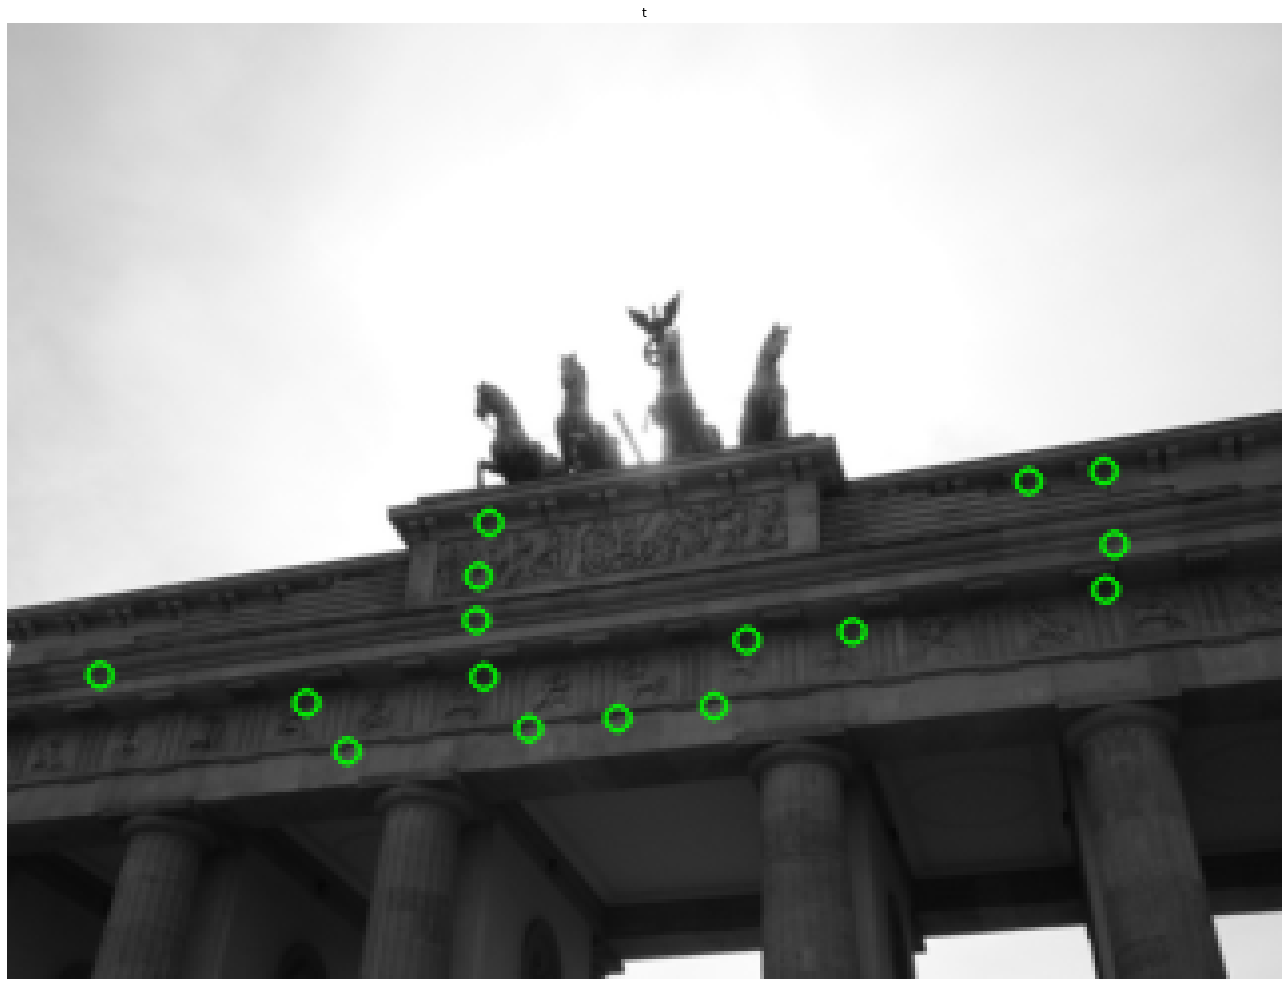

In [41]:
t = draw_cv_keypoints(image1, kp1 + dkp1, vis_kp_mask=grad1_col_mask)

plot_figures({"t": t})

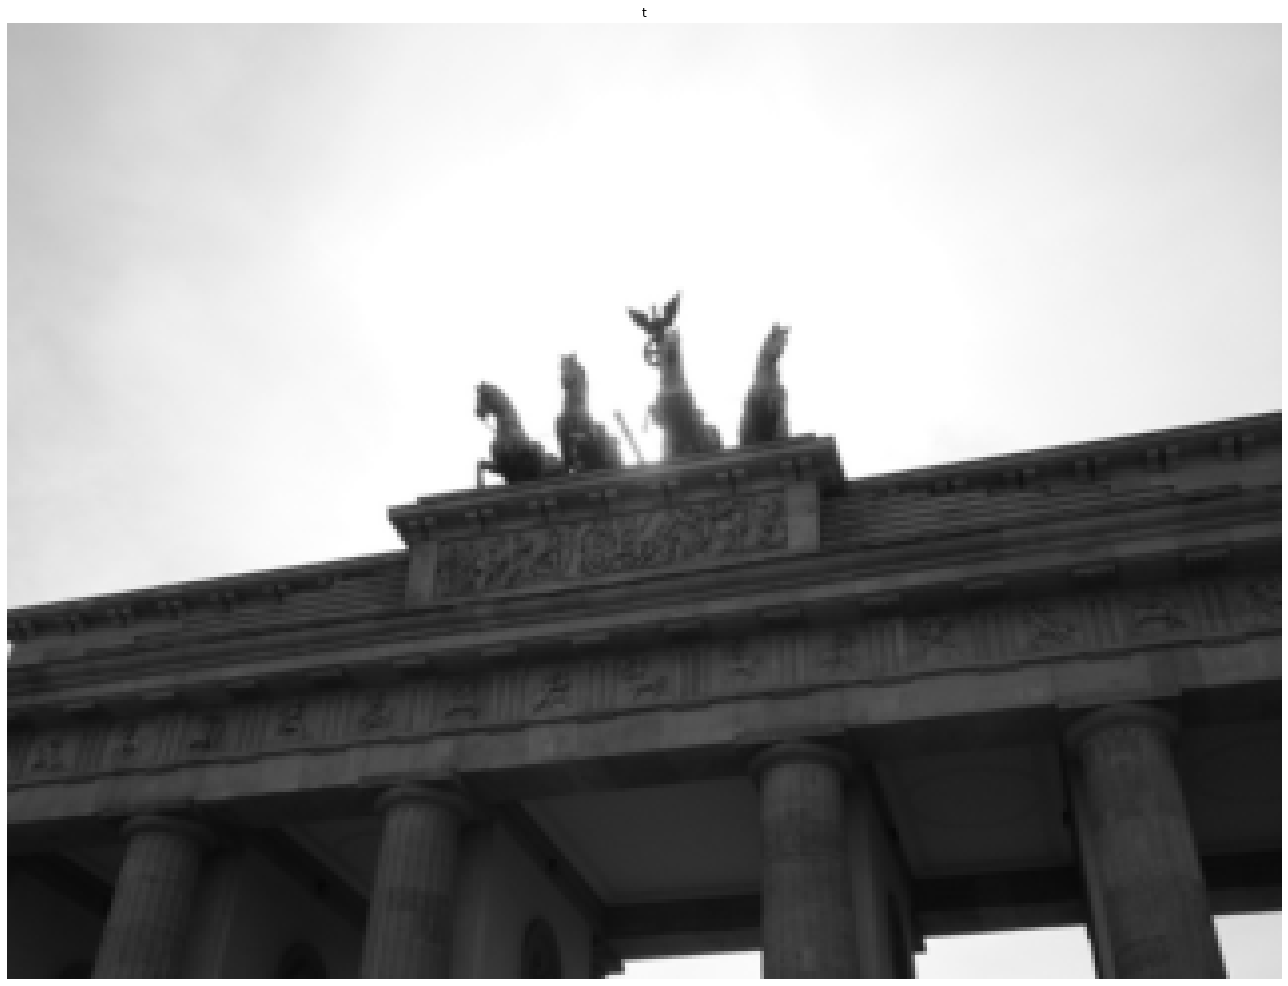

In [42]:
t = draw_cv_keypoints(image1, kp1 + dkp1, vis_kp_mask=grad1_n_col_mask)

plot_figures({"t": t})

In [59]:
# from Net.source.utils.math_utils import revert_data_transform, Rt, angle_mat, angle_vec, get_gt_rel_poses
# from Net.source.utils.matching_utils import get_gt_matches, select_kp
# from Net.source.utils.pose_utils import prepare_rel_pose

# _kp1 = kp1 + dkp1
# _kp2 = kp2 + dkp2

# _w_kp1, _w_kp2, _w_vis_kp1_mask, _w_vis_kp2_mask = warp_points(_kp1, _kp2, image1, image2, batch)

# mutual_gt_matches_mask, nn_kp_ids = get_gt_matches(_kp1, _kp2, _w_kp1, _w_kp2, _w_vis_kp1_mask, _w_vis_kp2_mask, 3.0)

# r_kp1 = revert_data_transform(_kp1, shift_scale1)
# r_kp2 = revert_data_transform(_kp2, shift_scale2)

# nn_r_kp2 = select_kp(r_kp2, nn_kp_ids)

# est_rel_pose = prepare_rel_pose(r_kp1, nn_r_kp2, mutual_gt_matches_mask, intrinsics1, intrinsics2, [3.0], False)
# gt_rel_pose = get_gt_rel_poses(extrinsics1, extrinsics2)

# r_err = angle_mat(est_rel_pose[0, :, :3, :3], gt_rel_pose[:, :3, :3])
# t_err = angle_vec(est_rel_pose[0, :, :3, 3], gt_rel_pose[:, :3, 3])

# print(r_err, t_err)

In [25]:
   # Pose loss
#     loss2 = pose_loss(_kp1, _w_kp1, _kp2, _w_kp2, _w_vis_kp1_mask, _w_vis_kp2_mask,
#                       intrinsics1, intrinsics2, extrinsics1, extrinsics2, shift_scale1, shift_scale2)
#     loss2.backward()
    
#     grad_mag1 = dkp1.grad.norm(dim=-1)
#     grad_mask1 = grad_mag1 > 0
#     avg_grad1 = grad_mag1.sum(dim=-1) / grad_mask1.float().sum(dim=-1).clamp(min=1e-8)
    
#     grad_mag2 = dkp2.grad.norm(dim=-1)
#     grad_mask2 = grad_mag2 > 0
#     avg_grad2 = grad_mag2.sum(dim=-1) / grad_mask2.float().sum(dim=-1).clamp(min=1e-8)
    
#     print(avg_grad1.mean())   
#     print(avg_grad2.mean())
    
#     epipolar_error = (epipolar_distance(to_original(kp1 + dkp1, shift_scale1), 
#                                         to_original(nn_kp2 + dkp2, shift_scale2), F) * gt_matches_mask.float()).sum() / gt_matches_mask.sum(dim=-1).float()
#     epipolar_error = epipolar_error.mean()
#     epipolar_error.backward()
    
#     ep_loss_grads = dkp1.grad[batch_idx][gt_matches_mask[batch_idx]]
#     dir_ep_loss_grads = normalize(ep_loss_grads)
    
#     ep_loss_grads2 = dkp2.grad[batch_idx][gt_matches_mask[batch_idx]]
#     dir_ep_loss_grads2 = normalize(ep_loss_grads2)
    
#     print("Norm ep", ep_loss_grads.norm(dim=-1).mean())
    
#     # Pose grads
#     optimizer.zero_grad()
    
#     epipolar_error = (epipolar_distance(to_original(kp1 + dkp1, shift_scale1), 
#                                         to_original(nn_kp2 + dkp2, shift_scale2), F) * gt_matches_mask.float()).sum() / gt_matches_mask.sum(dim=-1).float()
#     epipolar_error = epipolar_error.mean() * 0.015
    
#     E_gt = get_gt_parametrized_transform(intrinsics1, intrinsics2, extrinsics1, extrinsics2)
    
#     E_ests, _, success_mask = EstimateParamEssMat().apply(to_original(kp1 + dkp1, shift_scale1), 
#                                                           to_original(nn_kp2 + dkp2, shift_scale2), intrinsics1, intrinsics2, gt_matches_mask)
    
    
#     r_est, _ = cv2.Rodrigues(E_ests[batch_idx, :3].cpu().detach().numpy())
#     r_gt, _ = cv2.Rodrigues(E_gt[batch_idx, :3].cpu().detach().numpy())
    
#     t_par_est = np.concatenate([E_ests[batch_idx, 3:].cpu().detach().numpy(), [0]])
#     t_par_gt = np.concatenate([E_gt[batch_idx, 3:].cpu().detach().numpy(), [0]])
    
#     t_est, _ = cv2.Rodrigues(t_par_est)
#     t_gt, _ = cv2.Rodrigues(t_par_gt)
    
#     a = torch.tensor(t_est @ np.array([0, 0, 1]))
#     b = torch.tensor(t_gt @ np.array([0, 0, 1]))
    
#     print(torch.acos((a * b).sum(dim=-1)) * 180 / np.pi)
    
#     print(r_est)
#     print(r_gt)
    
#     print(angle_mat(torch.tensor(r_est).unsqueeze(0), torch.tensor(r_gt).unsqueeze(0)))

    # E_ests, _, success_mask = EstimateParamEssMat2().apply(to_original(kp1 + dkp1, shift_scale1), 
    #                                                        to_original(nn_kp2 + dkp2, shift_scale2), intrinsics1, intrinsics2, gt_matches_mask, F)
    
#     r_est_norm = normalize(E_ests[:, :3])
#     t_est_norm = normalize(E_ests[:, 3:])
    
#     r_gt_norm = normalize(E_gt[:, :3])
#     t_gt_norm = normalize(E_gt[:, 3:])

#     print(E_ests[0])
#     print(E_gt[0])

#     pose_error = (E_ests - E_gt).norm(dim=-1) * 0.25
#     loss = (E_ests[:, :3] - E_gt[:, :3]).norm(dim=-1) + (E_ests[:, 3:] - E_gt[:, 3:]).norm(dim=-1)
#     loss = inv_cos_sim_vec(r_est_norm.unsqueeze(1), r_gt_norm.unsqueeze(1)) + inv_cos_sim_vec(t_est_norm.unsqueeze(1), t_gt_norm.unsqueeze(1))
        
#     pose_error = pose_error.sum() / success_mask.float().sum().clamp(min=1e-8)

#     loss = pose_error + epipolar_error
    
#     print("Ep:", epipolar_error)
#     print("Pose:", pose_error)
#     print("Total", loss)

#     loss.backward()

#     optimizer.step()

#     pose_loss_grads = dkp1.grad[batch_idx][gt_matches_mask[batch_idx]]
#     dir_pose_loss_grads = normalize(pose_loss_grads)
    
#     print("Pose grad", pose_loss_grads.norm(dim=-1).mean())

#     pose_loss_grads2 = dkp2.grad[batch_idx][gt_matches_mask[batch_idx]]
#     dir_pose_loss_grads2 = normalize(pose_loss_grads2)

#     print(dir_ep_loss_grads[:2])
#     print(dir_pose_loss_grads[:2])
    
#     return dir_ep_loss_grads, dir_pose_loss_grads, dir_ep_loss_grads2, dir_pose_loss_grads2

# dir_ep_loss_grads, dir_pose_loss_grads, dir_ep_loss_grads2, dir_pose_loss_grads2 = step()

In [26]:
# batch_idx = 0

# sm_kp1 = kp1[batch_idx][gt_matches_mask[batch_idx]]

# m_w_kp2 = torch.gather(w_kp2, 1, nn_kp_ids1.unsqueeze(-1).repeat(1, 1, 2))
# sm_w_kp2 = m_w_kp2[batch_idx][gt_matches_mask[batch_idx]]

# from Net.source.utils.math_utils import to_original, to_homogeneous

# o_kp1 = to_original(kp1, shift_scale1)
# o_kp2 = to_original(kp2, shift_scale2)
# nn_o_kp2 = select_kp(o_kp2, nn_kp_ids1)

# F = compose_gt_transform(intrinsics1, intrinsics2, extrinsics1, extrinsics2)

# line1 = to_homogeneous(nn_o_kp2) @ F
# norm_line1 = line1 / line1[..., :2].norm(dim=-1).clamp(min=1e-16).unsqueeze(-1)

# sm_o_kp1 = o_kp1[batch_idx][gt_matches_mask[batch_idx]]
# sm_norm_line1 = norm_line1[batch_idx][gt_matches_mask[batch_idx]]

# sm_x_line_start = sm_o_kp1[:, 0] - 16
# sm_x_line_end = sm_o_kp1[:, 0] + 16

# sm_y_line_start = (-sm_norm_line1[:, 2] - sm_norm_line1[:, 0] * sm_x_line_start) / sm_norm_line1[:, 1]
# sm_y_line_end = (-sm_norm_line1[:, 2] - sm_norm_line1[:, 0] * sm_x_line_end) / sm_norm_line1[:, 1]

# sm_line_start = torch.cat([sm_x_line_start.unsqueeze(-1), sm_y_line_start.unsqueeze(-1)], dim=-1)
# sm_line_end = torch.cat([sm_x_line_end.unsqueeze(-1), sm_y_line_end.unsqueeze(-1)], dim=-1)

# line_start = (sm_line_start - shift_scale1[:, [1, 0]][batch_idx]) * shift_scale1[:, [3, 2]][batch_idx]
# line_end = (sm_line_end - shift_scale1[:, [1, 0]][batch_idx]) * shift_scale1[:, [3, 2]][batch_idx]

In [27]:
#         dir_ep_loss_grads, dir_pose_loss_grads, dir_ep_loss_grads2, dir_pose_loss_grads2 = 

In [95]:
align_mask = (dir_pose_loss_grads * dir_ep_loss_grads).sum(dim=-1) 

In [96]:
align_mask

tensor([ 0.7744, -0.5734,  0.4246, -0.8816,  0.9996,  0.9997,  0.9966,  0.9880,
         0.9506,  0.9998,  0.9572,  0.9738,  0.9321, -0.5138,  0.9520,  0.9941,
        -0.9413,  0.9951,  0.9869,  0.9997,  1.0000,  0.9999,  0.9420,  0.9999,
         0.9804,  0.8397,  0.9941, -0.6290,  0.9671,  0.9284,  0.9998,  0.9918,
         0.9925, -0.5118,  0.9476,  0.9996,  0.9987,  0.9943,  0.9849,  1.0000,
         0.9995,  0.9793,  0.9883,  0.9974,  0.9596,  0.9998,  0.9979,  0.9994,
         0.9093,  0.1143,  0.7328,  0.7441,  0.9997,  0.9917,  0.9841,  0.9974,
         0.9999,  0.0244, -0.8939, -0.1361,  0.9952,  0.9981,  0.9992, -0.8136,
         0.9992,  0.9900,  0.7757, -0.1064,  0.9999,  0.9834,  0.9506, -0.3079,
         0.8827,  0.3561,  0.9981,  0.9997,  0.8048,  0.9992,  0.9638,  0.9806,
         0.7846,  0.9795, -0.9685,  0.9598,  0.9904,  0.9867,  1.0000,  0.9991,
         0.9835,  0.9980,  0.9861,  0.6554,  0.2741,  0.9495,  0.9598,  0.8959,
         0.9941,  0.9999,  0.8837,  0.87

In [97]:
align_mask > 0

tensor([ True, False,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False, False,
         True,  True,  True, False,  True,  True,  True, False,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True],
       device='cuda:0')

In [60]:
(dir_ep_loss_grads * dir_ep_loss_grads2).sum(dim=-1)

tensor([-0.9992, -0.9992, -0.9991, -0.9992, -0.9992, -0.9991, -0.9992, -0.9992,
        -0.9992, -0.9991, -0.9992, -0.9992, -0.9992, -0.9991, -0.9992, -0.9992,
        -0.9992, -0.9992, -0.9991, -0.9992, -0.9992, -0.9992, -0.9992, -0.9992,
        -0.9991, -0.9991, -0.9992, -0.9991, -0.9992, -0.9992, -0.9992, -0.9992,
        -0.9992, -0.9991, -0.9992, -0.9992, -0.9992, -0.9992, -0.9992, -0.9992,
        -0.9992, -0.9992, -0.9992, -0.9992, -0.9992, -0.9991, -0.9991, -0.9992,
        -0.9992, -0.9991, -0.9992, -0.9992, -0.9992, -0.9992, -0.9992, -0.9991,
        -0.9992, -0.9992, -0.9992, -0.9992, -0.9991, -0.9991, -0.9992, -0.9992,
        -0.9992, -0.9991, -0.9992, -0.9992, -0.9992, -0.9992, -0.9992, -0.9992,
        -0.9992, -0.9992, -0.9991, -0.9992, -0.9992, -0.9992, -0.9992, -0.9992,
        -0.9991, -0.9992, -0.9991, -0.9992, -0.9992, -0.9992, -0.9992, -0.9992,
        -0.9992, -0.9992, -0.9993, -0.9992, -0.9991, -0.9991, -0.9992, -0.9991,
        -0.9992, -0.9992, -0.9992, -0.99

In [61]:
(dir_pose_loss_grads * dir_pose_loss_grads2).sum(dim=-1)

tensor([-0.9992, -0.9993, -0.9991, -0.9998, -0.9992, -0.9991, -0.9992, -0.9992,
        -0.9992, -0.9991, -0.9993, -0.9992, -0.9992, -0.9990, -0.9992, -0.9992,
        -0.9993, -0.9992, -0.9992, -0.9992, -0.9992, -0.9992, -0.9993, -0.9992,
        -0.9991, -0.9990, -0.9992, -0.9991, -0.9992, -0.9993, -0.9992, -0.9992,
        -0.9992, -0.9991, -0.9991, -0.9992, -0.9992, -0.9992, -0.9992, -0.9992,
        -0.9992, -0.9991, -0.9992, -0.9992, -0.9992, -0.9991, -0.9991, -0.9992,
        -0.9993, -0.9991, -0.9989, -0.9993, -0.9992, -0.9992, -0.9992, -0.9991,
        -0.9992, -0.9995, -0.9992, -0.9993, -0.9991, -0.9991, -0.9992, -0.9992,
        -0.9992, -0.9990, -0.9992, -0.9991, -0.9992, -0.9992, -0.9992, -0.9994,
        -0.9990, -0.9993, -0.9991, -0.9992, -0.9993, -0.9992, -0.9992, -0.9992,
        -0.9990, -0.9992, -0.9989, -0.9992, -0.9992, -0.9992, -0.9992, -0.9992,
        -0.9992, -0.9992, -0.9993, -0.9993, -0.9988, -0.9992, -0.9993, -0.9991,
        -0.9992, -0.9992, -0.9993, -0.99

In [62]:
# (epipolar_distance(to_original(kp1 + dkp1, shift_scale1), nn_o_kp2, F) * gt_matches_mask[0].float()).sum() / gt_matches_mask[0].sum(dim=-1).float()
# align_mask = (dir_pose_loss_grads * dir_ep_loss_grads).sum(dim=-1) > 0
# mg_pose.mean()
# mg_pose[~align_mask]
# mg_ep.mean()
# mg_ep[~align_mask]
# (E_ests[:, 3:] - E_gt[:, 3:]).norm(dim=-1)
# from Net.source.utils.math_utils import get_gt_rel_poses
# get_gt_rel_poses(extrinsics2, extrinsics1)[0][:,:3]
# kornia.geometry.angle_axis_to_rotation_matrix(E_ests[0][:3].unsqueeze(0))
# rot = torch.cat([E_ests[0][3:], torch.tensor(0.0).unsqueeze(0)])
# v1 = kornia.geometry.angle_axis_to_rotation_matrix((rot).unsqueeze(0)) @ torch.tensor([0.0, 0.0, 1.0])
# /v2 = get_gt_rel_poses(extrinsics2, extrinsics1)[0][2,:3]
# from Net.source.utils.math_utils import angle_vec
# angle_vec(v1, v2)
# E_ests[0][:3]


In [63]:
sm_kp1_pose_grad = sm_kp1 - 8 * dir_pose_loss_grads 
sm_kp1_ep_grad = sm_kp1 - 8 * dir_ep_loss_grads

In [64]:
cv_s_image1 = torch2cv(s_image1[batch_idx])
cv_s_image2 = torch2cv(s_image2[batch_idx])

In [65]:
cv_markers_s_image1 = cv2.UMat(cv_s_image1)

for i, j, k in zip(line_start, line_end, sm_kp1):
    cv_markers_s_image1 = cv2.drawMarker(cv_markers_s_image1, tuple(k.cpu().numpy()[[1, 0]]), (255, 255, 255), markerSize=7)
    cv_markers_s_image1 = cv2.line(cv_markers_s_image1, tuple(i), tuple(j), (255, 0, 0))
    

# for i, j in zip(sm_kp1, sm_w_kp2):
#     cv_markers_s_image1 = cv2.drawMarker(cv_markers_s_image1, tuple(i.cpu().numpy()[[1, 0]]), (255, 0, 0), markerSize=7)
#     cv_markers_s_image1 = cv2.drawMarker(cv_markers_s_image1, tuple(j.cpu().numpy()[[1, 0]]), (0, 0, 0), markerSize=7)

In [66]:
cv_line_keypoints_s_image1 = cv_markers_s_image1

for i, j, k in zip(sm_kp1, sm_kp1_pose_grad, sm_kp1_ep_grad):
    cv_line_keypoints_s_image1 = cv2.line(cv_line_keypoints_s_image1,
                                      tuple(i.cpu().numpy()[[1, 0]]), 
                                      tuple(k.cpu().numpy()[[1, 0]]), 
                                      (0, 255, 0))
    cv_line_keypoints_s_image1 = cv2.line(cv_line_keypoints_s_image1,
                                          tuple(i.cpu().numpy()[[1, 0]]), 
                                          tuple(j.cpu().numpy()[[1, 0]]), 
                                          (0, 0, 255))
        

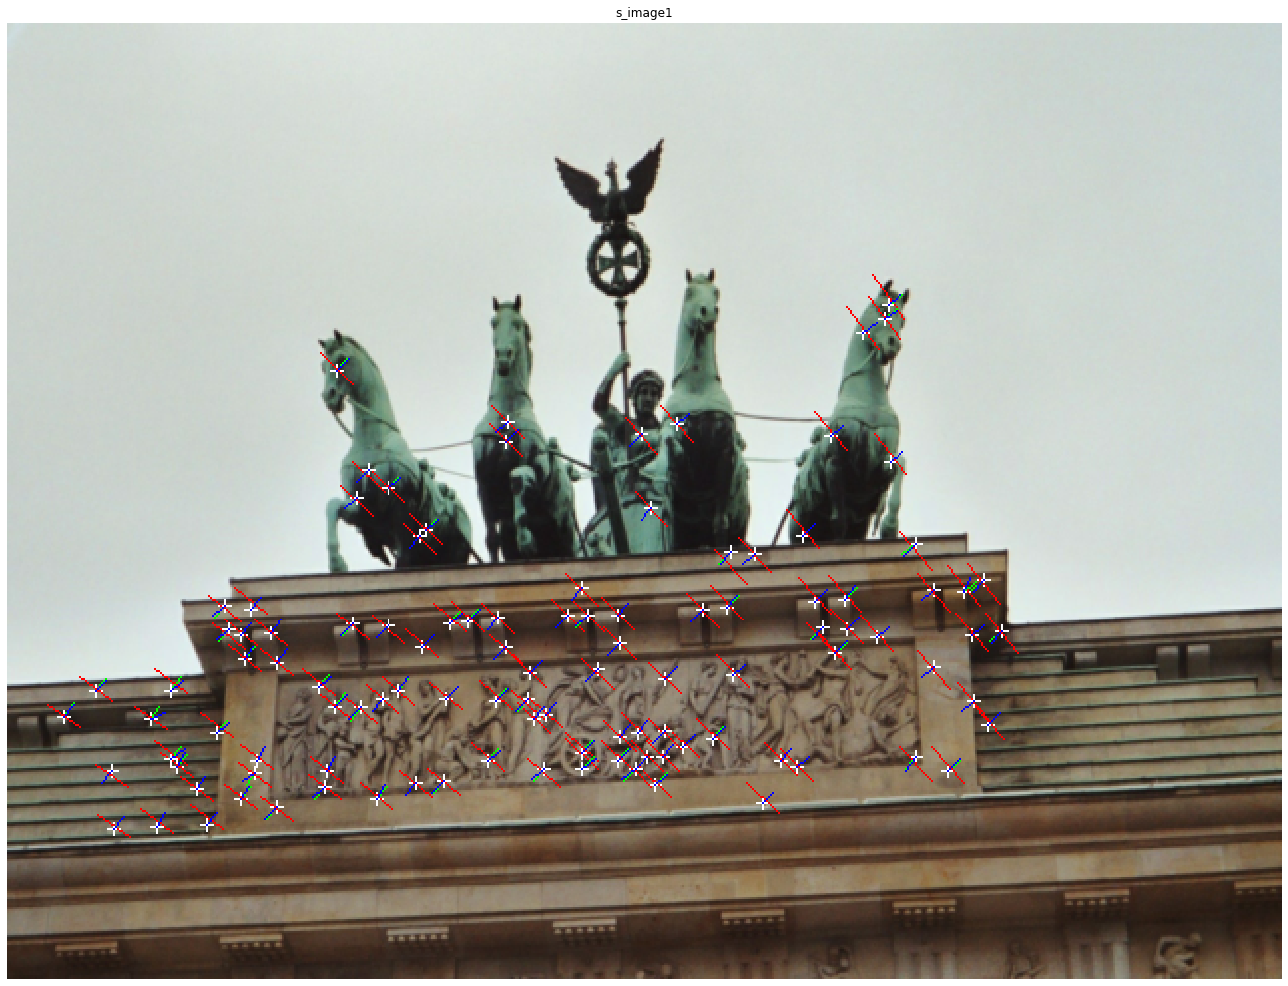

In [67]:
plot_figures({'s_image1': cv2.UMat.get(cv_line_keypoints_s_image1)}, 
              1, 1, (18, 18))

In [24]:
from Net.source.utils.math_utils import to_original

o_kp1 = to_original(kp1, shift_scale1)
o_kp2 = to_original(kp2, shift_scale2)
nn_o_kp2 = select_kp(o_kp2, nn_kp_ids1)

In [25]:
from Net.source.utils.optimization_utils import get_gt_parametrized_transform, EstimateParamEssMat

estimator = EstimateParamEssMat().apply

E_gt = get_gt_parametrized_transform(intrinsics1, intrinsics2, extrinsics1, extrinsics2)

print(E_gt)

tensor([[ 0.3439, -0.1334,  0.1828, -0.1698, -0.4837],
        [-0.1139,  0.3056, -0.0949, -0.3471,  0.8212]], device='cuda:0')


In [26]:
E_ests_0, E_init_0, success = estimator(o_kp1, nn_o_kp2, intrinsics1, intrinsics2, gt_matches_mask[0])

In [27]:
print((E_gt - E_init_0).norm(dim=-1), "Initial error")

tensor([0.1036, 0.1313], device='cuda:0') Initial error


In [28]:
print((E_gt - E_ests_0).norm(dim=-1), "Opt. error")

tensor([0.0234, 0.4152], device='cuda:0') Opt. error


In [29]:
noise_kp1 = torch.randn((1, 512, 2)).to(experiment.device).repeat(2, 1, 1)

In [30]:
# E_noise_ests_0, E_noise_init_0, success = \
#     estimator(to_original(kp1 + noise_kp1, shift_scale1), nn_o_kp2, intrinsics1, intrinsics2, gt_matches_mask[0])

In [31]:
# print((E_gt - E_noise_init_0).norm(dim=-1), "Initial error noise")

In [32]:
# print((E_gt - E_noise_ests_0).norm(dim=-1), "Opt. error noise")

In [256]:
dkp1 = torch.nn.Parameter(torch.zeros_like(kp1, requires_grad=True))
optimizer  = torch.optim.Adam([dkp1])

In [257]:
F = compose_gt_transform(intrinsics1, intrinsics2, extrinsics1, extrinsics2)

In [258]:
estimator = EstimateParamEssMat().apply

In [262]:
from Net.source.utils.math_utils import epipolar_distance
from torch.nn.functional import normalize

idx = 1

for i in range(1, 15):
    optimizer.zero_grad()
    
    epipolar_error = (epipolar_distance(to_original(kp1 + dkp1, shift_scale1), nn_o_kp2, F) * gt_matches_mask[0].float()).sum() / gt_matches_mask[0].sum(dim=-1).float()
    epipolar_error = epipolar_error.mean()
    
    epipolar_error.backward()
    
    print(f"iteration {i}. Epipolar distance is: {epipolar_error}")
    
    g2 = dkp1.grad[idx][gt_matches_mask[0][idx]]
    
    optimizer.zero_grad()
    
    E_ests, _, success_mask = estimator(to_original(kp1 + noise_kp1 + dkp1, shift_scale1), nn_o_kp2, intrinsics1, intrinsics2, gt_matches_mask[0])
    
    loss = (E_ests - E_gt).norm(dim=-1)
    
    loss = loss.sum() / success_mask.float().sum().clamp(min=1e-8)
    
    loss.backward()
    
    optimizer.step()
    
    g1 = dkp1.grad[idx][gt_matches_mask[0][idx]]
    
    g1 = normalize(g1)
    g2 = normalize(g2)
    
#     print((g1 * g2).sum(dim=-1))
    
    print(f"iteration {i} loss value is {loss}")
    

iteration 1. Epipolar distance is: 52.63117599487305
iteration 1 loss value is 114234304.0
iteration 2. Epipolar distance is: 52.63117599487305
iteration 2 loss value is 114234304.0
iteration 3. Epipolar distance is: 52.63117599487305
iteration 3 loss value is 114234304.0
iteration 4. Epipolar distance is: 52.63117599487305
iteration 4 loss value is 114234304.0
iteration 5. Epipolar distance is: 52.63117599487305
iteration 5 loss value is 114234304.0
iteration 6. Epipolar distance is: 52.63117599487305
iteration 6 loss value is 114234304.0
iteration 7. Epipolar distance is: 52.63117599487305
iteration 7 loss value is 114234304.0
iteration 8. Epipolar distance is: 52.63117599487305
iteration 8 loss value is 114234304.0
iteration 9. Epipolar distance is: 52.63117599487305
iteration 9 loss value is 114234304.0
iteration 10. Epipolar distance is: 52.63117599487305
iteration 10 loss value is 114234304.0
iteration 11. Epipolar distance is: 52.63117599487305
iteration 11 loss value is 1142343

In [ ]:
# torch.nonzero(dkp1.grad)

In [ ]:
# from Net.source.nn.net.criterion import PoseLoss, EpipolarLoss

# pose_loss = PoseLoss(1.0)
# pose_loss = EpipolarLoss(1.0, 5.0, None)

In [ ]:
# pose_loss(kp1 + dkp1, w_kp1, kp2 + dkp2, w_kp2, w_vis_kp1_mask, w_vis_kp2_mask,
#           intrinsics1, intrinsics2, extrinsics1, extrinsics2, shift_scale1, shift_scale2).backward()
# pose_loss(kp1 + dkp1, w_kp1, kp2 + dkp2, w_kp2, w_vis_kp1_mask, w_vis_kp2_mask, None, None,
#           intrinsics1, intrinsics2, extrinsics1, extrinsics2, shift_scale1, shift_scale2).backward()

In [ ]:

from Net.source.utils.math_utils import to_original, epipolar_distance, compose_gt_transform

o_kp1 = to_original(kp1 + dkp1, shift_scale1)
o_kp2 = to_original(kp2 + dkp2, shift_scale2)
nn_o_kp2 = select_kp(o_kp2, nn_kp_ids1)

F = compose_gt_transform(intrinsics1, intrinsics2, extrinsics1, extrinsics2)

In [ ]:
print((epipolar_distance(o_kp1, nn_o_kp2, F) * gt_matches_mask.float()).sum() / gt_matches_mask.sum(dim=-1).float())

In [ ]:
epipolar_grad = dkp1.grad[0][gt_matches_mask[0][0]]

In [ ]:
pose_grad = dkp1.grad[0][gt_matches_mask[0][0]]

In [ ]:
from torch.nn.functional import normalize

ep_norm = normalize(epipolar_grad)
pose_norm = normalize(pose_grad)

print((ep_norm * pose_norm).sum(dim=-1))


In [ ]:
(epipolar_grad.norm(dim=-1) - pose_grad.norm(dim=-1)).mean()

In [ ]:
o_new_kp1 = to_original(kp1 + dkp1.grad, shift_scale1)
o_new_kp2 = to_original(kp2 + dkp2.grad, shift_scale2)
nn_o_new_kp2 = select_kp(o_new_kp2, nn_kp_ids1)

print((epipolar_distance(o_new_kp1, nn_o_new_kp2, F) * gt_matches_mask.float()).sum() / gt_matches_mask.sum(dim=-1).float())

In [ ]:
# E_gt = get_gt_parametrized_transform(intrinsics1, intrinsics2, extrinsics1, extrinsics2)

In [ ]:
# from Net.source.utils.matching_utils import get_best_gt_matches, select_kp
# from Net.source.utils.math_utils import to_original, epipolar_distance, compose_gt_transform

# gt_matches_mask, nn_kp_ids1 = \
#     get_best_gt_matches(kp1, w_kp1, kp2, w_kp2, w_vis_kp1_mask, w_vis_kp2_mask, [5.0], mutual=False)

# o_kp1 = to_original(kp1 + dkp1, shift_scale1)
# o_kp2 = to_original(kp2 + dkp2, shift_scale2)
# nn_o_kp2 = select_kp(o_kp2, nn_kp_ids1)

In [ ]:
# # Initial epipolar distance
# 

# print((epipolar_distance(o_kp1, nn_o_kp2, F) * gt_matches_mask.float()).sum() / gt_matches_mask.sum(dim=-1).float())

In [ ]:
# est = EstimateParamEssMat().apply

# E_ests, E_init_ests, success_mask = est(o_kp1, nn_o_kp2, intrinsics1, intrinsics2, gt_matches_mask[0])

In [ ]:
# E_ests[0][:3].norm() < 1e-8

In [ ]:
# R_est, R_gt = E_ests[:, :3], E_gt[:, :3]
# t_est, t_gt = E_ests[:, 3:], E_gt[:, 3:]

# R_diff = R_est - R_gt
# t_diff = t_est - t_gt

In [ ]:
# loss = (R_diff.norm(dim=-1) + t_diff.norm(dim=-1)) * success_mask.float()
# loss = loss.sum() / success_mask.float().sum().clamp(min=1e-8)

In [ ]:
# loss.backward()

In [ ]:
# o_new_kp1 = to_original(kp1 + dkp1.grad, shift_scale1)
# o_new_kp2 = to_original(kp2 + dkp2.grad, shift_scale2)
# nn_o_new_kp2 = select_kp(o_new_kp2, nn_kp_ids1)


In [ ]:
# print((epipolar_distance(o_new_kp1, nn_o_new_kp2, F) * gt_matches_mask.float()).sum() / gt_matches_mask.sum(dim=-1).float())
